In [1]:
import grid_gen as gg
import numpy as np
#Import libraries to make tables
import pandas as pd
from IPython.display import display, HTML

## **Part 1:** Amsden-Hirst vs Winslow

We begin by testing the grid generation algorithm out on the dome domain.

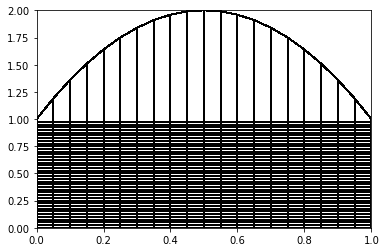

In [2]:
dome_grid = gg.gridGen(*gg.make_dome(41,21))
dome_grid.plot()

Using the above initial guess, we obtain

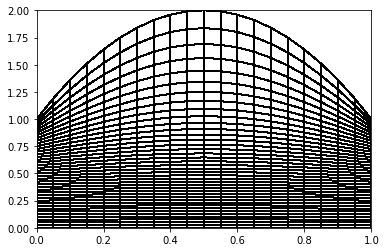

In [3]:
its = dome_grid.solve(algo='AH')
dome_grid.plot()

In [4]:
print("Iterations {}, Omega {}".format(its, dome_grid.omega))

Iterations 63, Omega 1.78803222052


However, it doesn't do so well on the swan domain.

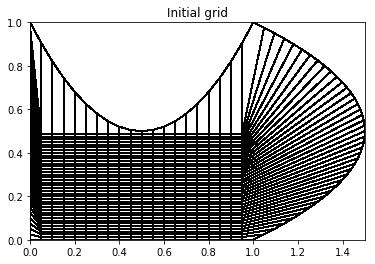

In [5]:
swan_grid = gg.gridGen(*gg.make_swan(41,21))
swan_grid.plot(title="Initial grid")

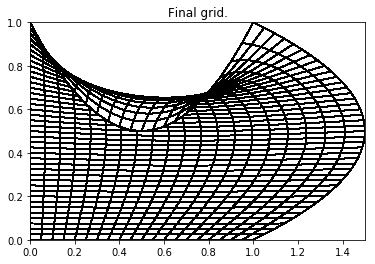

Iterations 65


In [6]:
its = swan_grid.solve(algo="AH")
swan_grid.plot(title="Final grid.")
print("Iterations {}".format(its))

Evidently something went wrong here - the transformation is non-injective. We can verify this by creating a surface plot of the Jacobian.

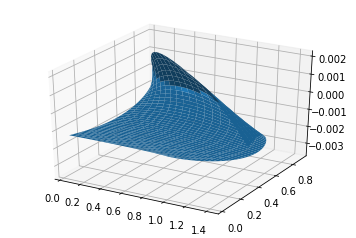

Minimum of Jacobian magnitude is 4.42710137906e-06 at (0.804804992796,0.678707229019)


In [7]:
min_jac, x_coord, y_coord = swan_grid.jacobian(plot=True)
print("Minimum of Jacobian magnitude is {} at ({},{})".format(min_jac, x_coord,y_coord))

The Jacobian is clearly changing sign - and is zero in a number of places. This problem is solved by switching to the Winslow algorithm.

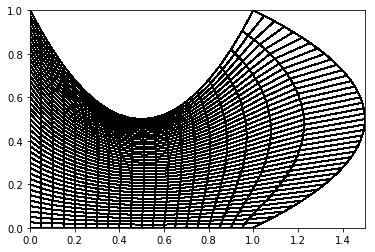

Converged in 98 iterations.


In [8]:
swan_grid.reset()
its = swan_grid.solve(algo="Winslow")
swan_grid.plot()
print("Converged in {} iterations.".format(its))

This fixed the problem with Amsden-Hirst. There is no visible folding. We can double-check the Jacobian.

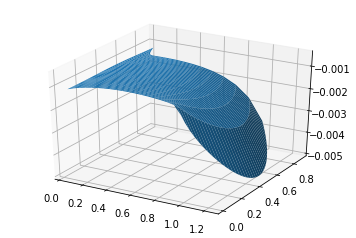

Minimum of Jacobian magnitude is 0.000424471687846 at (0.500746648073,0.491704250037)


In [9]:
min_jac, x_coord, y_coord = swan_grid.jacobian(plot=True)
print("Minimum of Jacobian magnitude is {} at ({},{})".format(min_jac, x_coord,y_coord))

While the Jacobian is approaching zero at the upper boundary, it does not change sign in the domain.

## **Part 2:** Convergence and Choosing Omega

We now can ask how the choice of omega affects the convergence, and how convergence rates vary between domains and algorithms. First, we verify that the optimal Omega for AH is the one provided in the lecture ones.

In [10]:
dome_omega_test = gg.gridGen(*gg.make_dome(41,61))
print("Default Omega from lecture notes {}.".format(dome_omega_test.omega))

Default Omega from lecture notes 1.87752043541.


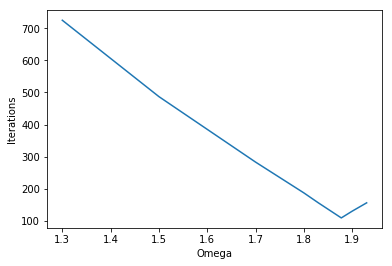

[725, 487, 283, 187, 156, 109, 130, 156]

In [11]:
test_omegas = [1.3,1.5,1.7,1.8,1.83, 1.8775, 1.9, 1.93]
dome_omega_test.test_omegas(test_omegas, algo="AH", plot=True)

Indeed, the theory holds for AH. It is interesting to note that the iterations required appear to increase linearly with the error between omega and the theoretical optimum. Let's try the same experiment with Winslow.

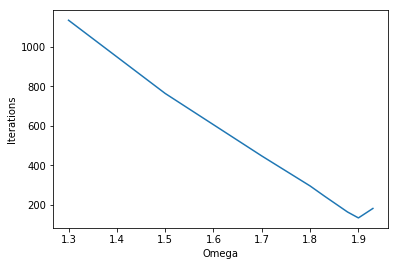

[1135, 764, 447, 295, 243, 163, 133, 181]

In [12]:
dome_omega_test.reset()
dome_omega_test.test_omegas(test_omegas, algo="Winslow", plot=True)

The optimal value of omega for Winslow's algorithm in this case appears to be 1.9, a little higher than the optimal value of 1.87 used for AH. However, convergence still occurs for all values of omega.
To sum everything up, we'll make a tables for both on the two domains we considered.

In [13]:
table = gg.do_experiment([(61,41),(61,61)], algo="AH")
print("AH Results")
display(HTML(table.to_html(index=False)))

AH Results


Domain,Domain Size,Min Jacobian,Minimizer,NumIts
swan,"(61, 41)",7.303159e-07,"(0.436, 0.616)",104
swan,"(61, 61)",6.963342e-08,"(0.452, 0.543)",126
dome,"(61, 41)",4.195210e-04,"(0.025, 0.034)",104
dome,"(61, 61)",2.818412e-04,"(0.017, 0.034)",125


In [14]:
table = gg.do_experiment([(61,41),(61,61)], algo="Winslow")
print("Winslow Results")
display(HTML(table.to_html(index=False)))

Winslow Results


Domain,Domain Size,Min Jacobian,Minimizer,NumIts
swan,"(61, 41)",0.000140,"(0.500, 0.494)",206
swan,"(61, 61)",0.000093,"(0.484, 0.495)",244
dome,"(61, 41)",0.000418,"(0.025, 0.017)",198
dome,"(61, 61)",0.000279,"(0.017, 0.017)",307


As we can see, Winslow takes more iterations to converge. In my experiments, I found that in some cases using the optimal AH omega for Winslow resulted in no convergence. I found that omega=1.8 worked well for Winslow across domains. However, this is probably less than optimal for any given domain.


## **Part 3:** Multiply Connected Domains

The previous two algorithms we investigated are for simply connected domains. However, we can extend the Winslow algorithm to handle a single hole in the domain.

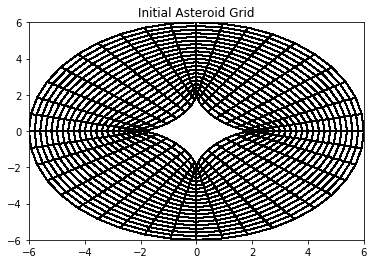

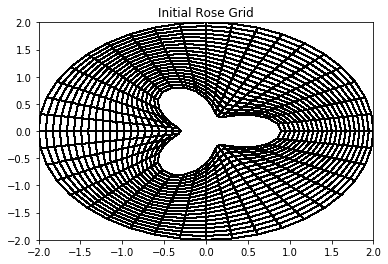

In [15]:
asteroid_grid = gg.gridGen(*gg.make_asteroid(41,21),multiply_connected=True, omega=1.8)
rose_grid = gg.gridGen(*gg.make_rose(41,21),multiply_connected=True, omega=1.8)
asteroid_grid.plot(title="Initial Asteroid Grid")
rose_grid.plot(title="Initial Rose Grid")

To choose the initlal grids, I linearly interpolated between the interior and exteroir boundary in the radial direction. These initial guesses ended up being very good and leading to rapid convergence.

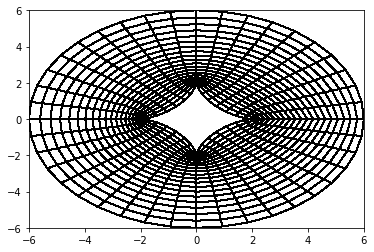

Asteroid grid converged in 65 iterations


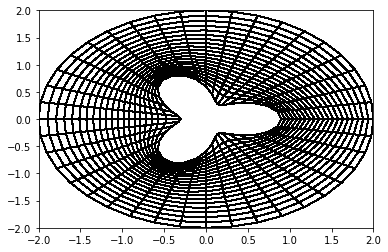

Rose grid converged in 44 iterations


In [16]:
a_its = asteroid_grid.solve(algo="Winslow")
asteroid_grid.plot()
print "Asteroid grid converged in {} iterations".format(a_its)
r_its = rose_grid.solve(algo="Winslow")
rose_grid.plot()
print "Rose grid converged in {} iterations".format(r_its)

Visually, the difference between the final grid and the initial guess are minor. This attests to the quality of the initial guess.
As in the previous section, we can investigate convergence and the optimal choice of omega. First, we see what results we get using the baseline of Omega=1.8.

In [17]:
table = gg.do_experiment([(71,21),(71,41)], algo="Winslow", multiply_connected=True)
print("Winslow Results On MC Domains")
display(HTML(table.to_html(index=False)))

Winslow Results On MC Domains


Domain,Domain Size,Min Jacobian,Minimizer,NumIts
rose,"(71, 21)",0.002141,"(-0.438, -0.813)",56
rose,"(71, 41)",0.001004,"(-0.432, -0.802)",138
asteroid,"(71, 21)",0.000964,"(-2.015, -0.000)",85
asteroid,"(71, 41)",0.000139,"(-2.004, -0.000)",193


Let's take the worst-performing grid, and see if we can improve the choice of Omega. We'll center our guesses about omega=1.8.

('Omegas', array([1.7       , 1.71888889, 1.73777778, 1.75666667, 1.77555556,
       1.79444444, 1.81333333, 1.83222222, 1.85111111, 1.87      ]))


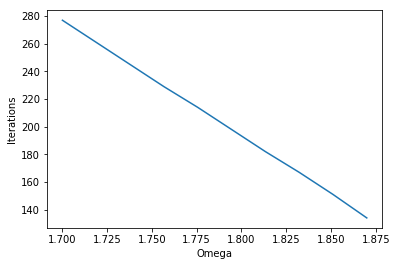

[277, 261, 245, 229, 214, 198, 182, 167, 151, 134]

In [18]:
asteroid_omega = gg.gridGen(*gg.make_asteroid(71,41),multiply_connected=True)
omegas = np.linspace(1.7,1.87,10)
print("Omegas", omegas)
asteroid_omega.test_omegas(omegas, algo="Winslow",plot=True)

Evidently, the guess of 1.8 is pretty off for this grid! The plot suggests the optimal omega is greater than 1.87. Let's explore more values!

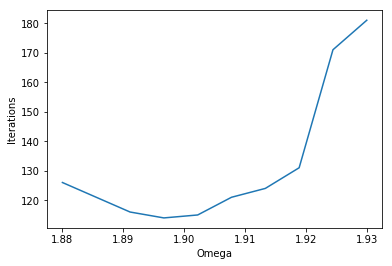

[126, 121, 116, 114, 115, 121, 124, 131, 171, 181]

In [19]:
asteroid_omega.reset()
asteroid_omega.test_omegas(np.linspace(1.88,1.93,10),plot=True, algo="Winslow")

The optimal omega for this grid is somewhere around 1.895.

That's all, folks! This project was fun for me - it was rewarding to see the theory come to life. I found the iterative algorithms a lot simpler to implement than the direct solvers in earlier projects.